DATA LOADING AND PREPARATION

In [ ]:
# Step 1: Installation of necessary modules
!pip install pyspark
!pip install imbalanced-learn

In [ ]:
# Step2: Importing of essencial libraries
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC

In [ ]:
# Step 3: Loading of the dataset and preliminary data checks
df = pd.read_csv('dataset.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# step 4: Check Date Dimension
df.shape

(7043, 21)

In [ ]:
# Step 5: Check Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Step 6: Definition target and feature columns.
target_col = ['Churn']
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [ ]:
# Step 7: Dropping customerID column if it exists
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

In [ ]:
# Step 8: Splitting of the data into training and testing sets.
train, test = train_test_split(df, test_size=0.2, random_state=42)

train.shape

(5634, 20)

EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
# Step 9: Checking for missing values in train dataset
missing_values = train.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
Churn                0
dtype: int64


In [ ]:
# Step 10: Checking for missing values in test dataset
missing_values = test.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        1
Churn               0
dtype: int64


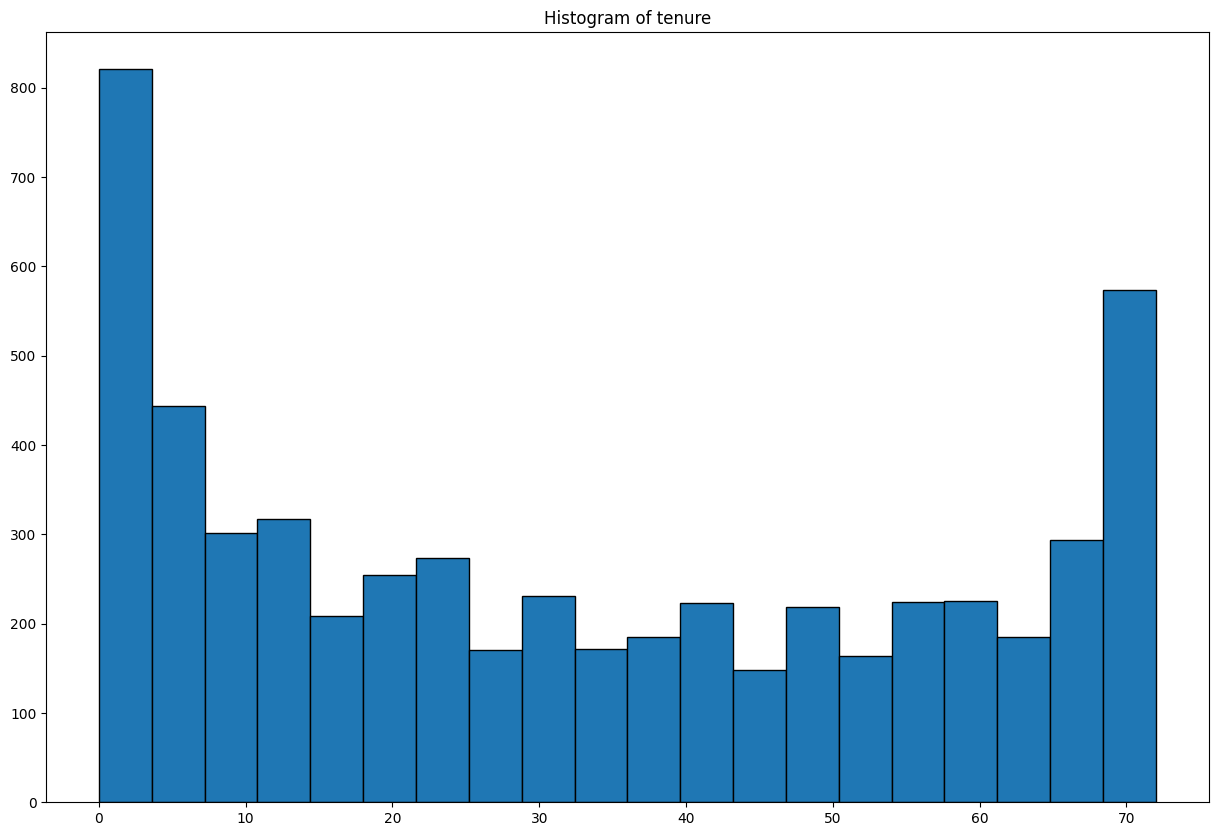

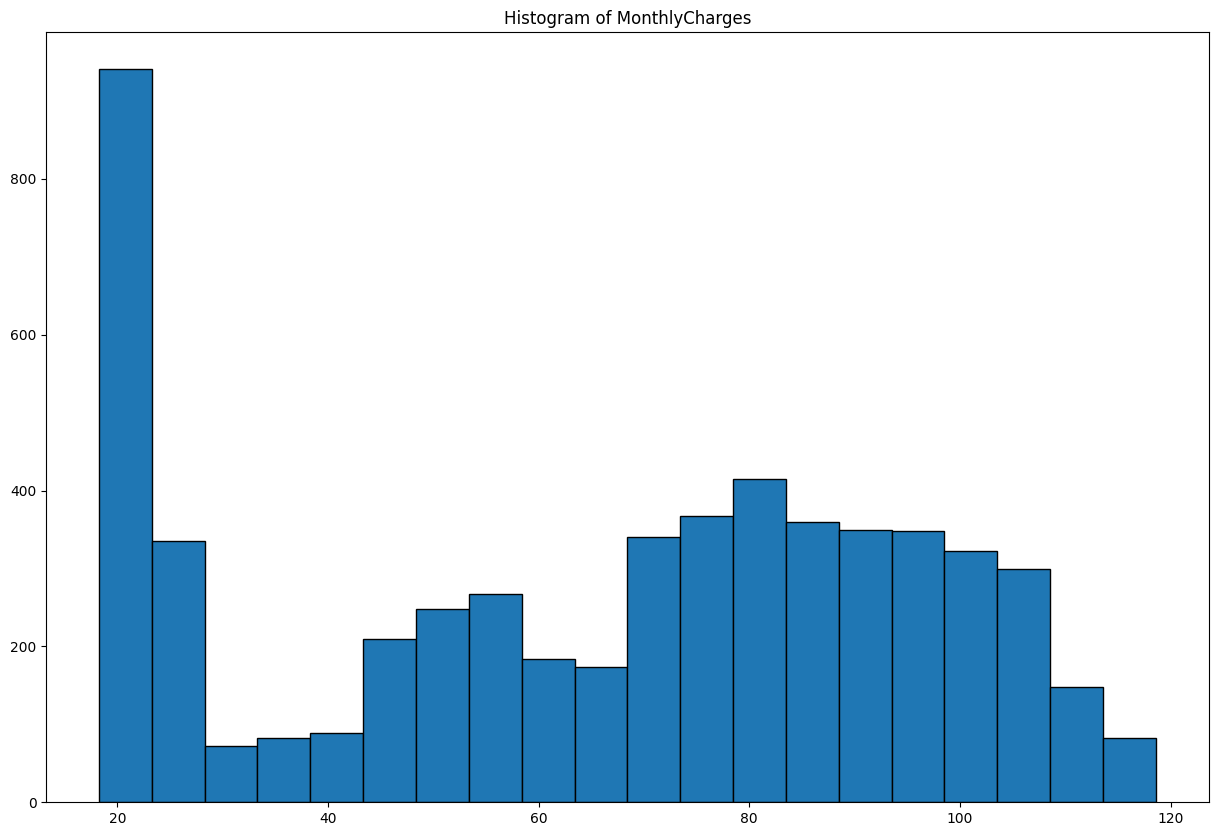

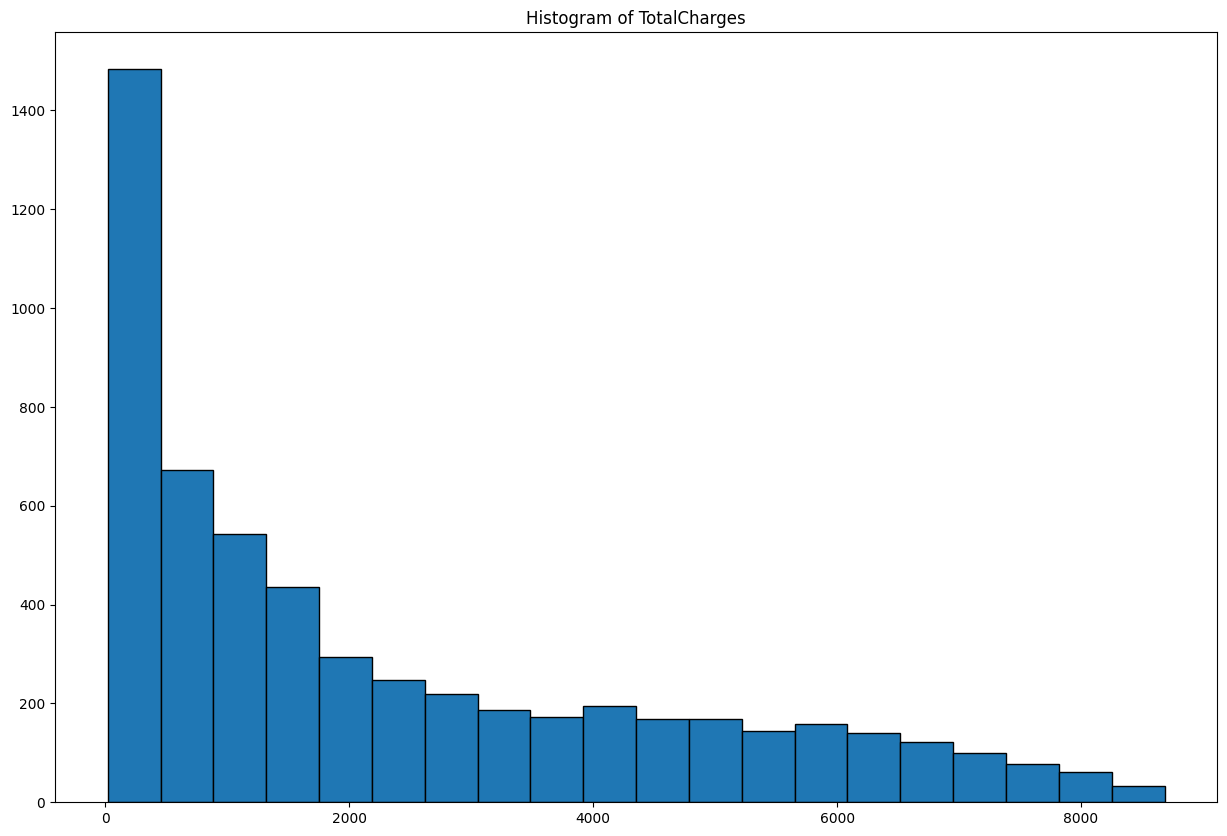

In [ ]:
# Step 11: Identifying outliers in numerical columns using histograms on train dataset
for col in numerical_cols:
    plt.figure(figsize=(15, 10))
    plt.title(f'Histogram of {col}')
    plt.hist(train[col], bins=20, edgecolor='k')
    plt.show()

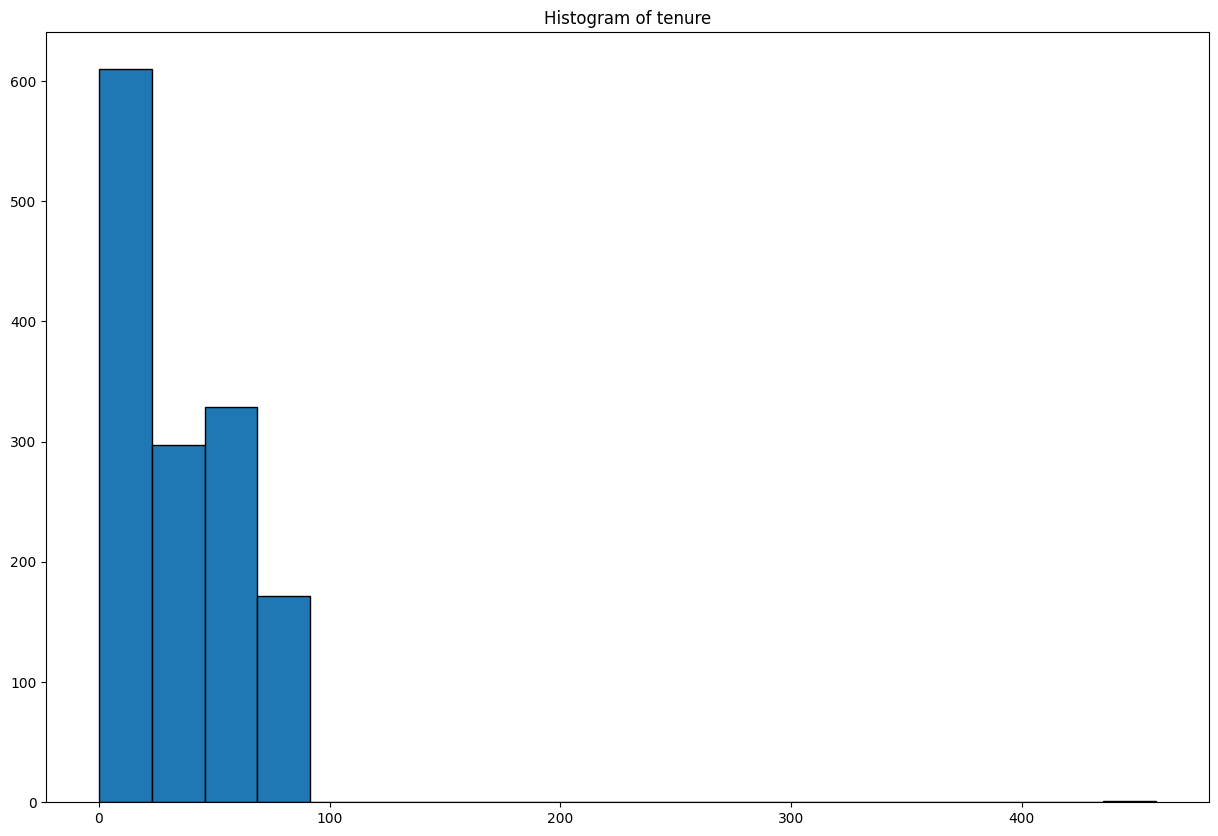

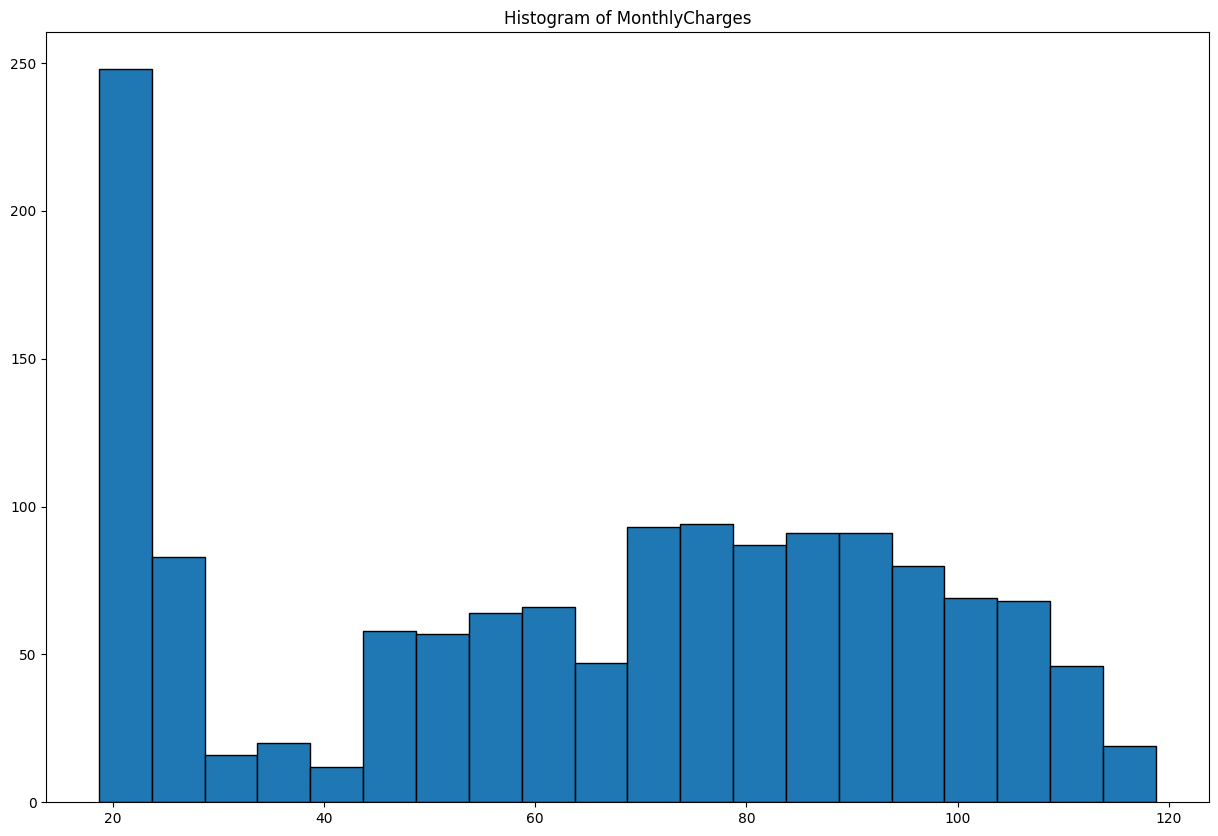

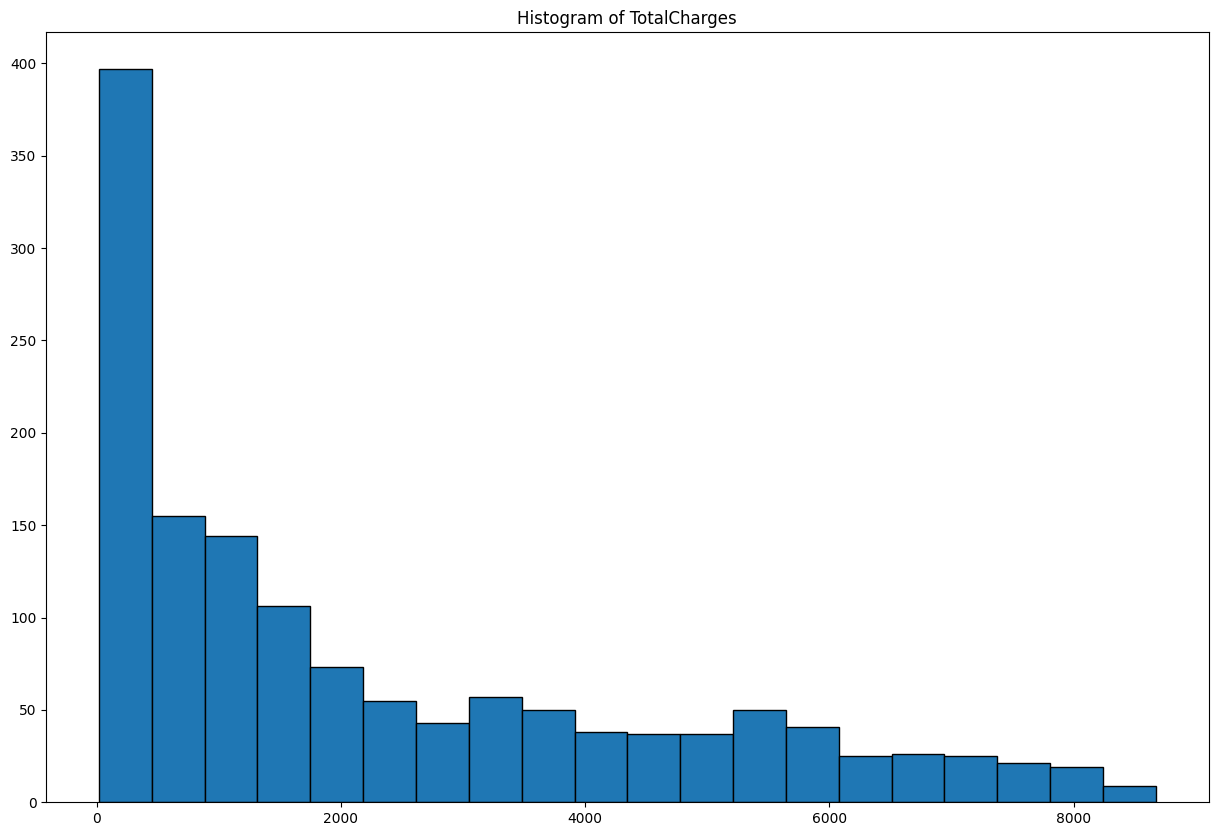

In [ ]:
# Step 12: Identify outliers in numerical columns using histograms on test dataset
for col in numerical_cols:
    plt.figure(figsize=(15, 10))
    plt.title(f'Histogram of {col}')
    plt.hist(test[col], bins=20, edgecolor='k')
    plt.show()

In [ ]:
# Step 13: Checking Class Imbalance
churn_counts = train['Churn'].value_counts()
print("Churn Counts:\n", churn_counts)

Churn Counts:
 Churn
No     4138
Yes    1496
Name: count, dtype: int64


DATA CLEANING

In [ ]:
# Step 14: Imputation of missing values using the mean strategy.
imputer = SimpleImputer(strategy='mean')
train['TotalCharges'] = imputer.fit_transform(train[['TotalCharges']])
test['TotalCharges'] = imputer.transform(test[['TotalCharges']])


In [ ]:
# Step 15: Removal of outliers.
test = test[test['tenure'] <= 100]

# Verify the removal of outliers
print(test.describe())

            tenure  MonthlyCharges  TotalCharges
count  1408.000000     1408.000000   1408.000000
mean     32.384233       64.343821   2253.382283
std      25.097325       30.109406   2281.082746
min       0.000000       18.700000     18.900000
25%       8.000000       34.687500    354.837500
50%      28.000000       69.775000   1344.000000
75%      56.000000       89.650000   3740.312500
max      72.000000      118.750000   8672.450000


HANDLING CLASS IMBALANCE USING SMOTE-NC

In [ ]:
# Step 16: SMOTENC process
categorical_indices = [train.columns.get_loc(col) for col in categorical_cols]

X_train = train.drop(target_col, axis=1)
y_train = train[target_col]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train.values.ravel())

train_resampled_pd = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled, name=target_col[0])], axis=1)

train_resampled_pd.shape

(8276, 20)

In [ ]:
train_resampled_pd.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.800000,No
1,Female,No,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.450000,No
2,Male,No,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.450000,Yes
3,Male,No,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.950000,Yes
4,Male,No,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,2291.154605,No


PREPARATION OF NUMERICAL AND CATEGORICAL FEATURES

In [ ]:
# Step 17: Starting a Spark session.
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

In [ ]:
# Step 18: Converting Pandas DataFrames to PySpark DataFrames
train_spark = spark.createDataFrame(train_resampled_pd)
test_spark = spark.createDataFrame(test)
test_spark.show(5)

+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|

In [ ]:
# Step 19: Numerical Feature
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")

# Step 20: Categorical Feature
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_cols]
categorical_assembler = VectorAssembler(inputCols=[col + "_encoded" for col in categorical_cols], outputCol="encoded_categorical_features")

# Step 21: Target Variable (Churn)
churn_indexer = StringIndexer(inputCol=target_col[0], outputCol="churn_indexed")

# Step 22: Final Feature Assembly
final_assembler = VectorAssembler(inputCols=["scaled_numerical_features", "encoded_categorical_features"], outputCol="final_features")


BUILDING AND TRAINING RANDOM FOREST CLASSIFIER MODEL USING PIPELINE

In [ ]:
# Step 23: Initialize Random Forest Classifier
rf = RandomForestClassifier(featuresCol="final_features", labelCol="churn_indexed", numTrees=40)


In [ ]:
# Step 24: Define the pipeline with the stages
pipeline_rf = Pipeline(stages=[numerical_assembler, scaler, *indexers, *encoders, categorical_assembler, churn_indexer, final_assembler, rf])


In [ ]:
# Step 25: Train Pipeline Model
model_rf = pipeline_rf.fit(train_spark)

In [ ]:
# Step 26: Generate predictions on the test data
predictions_rf = model_rf.transform(test_spark)
predictions_rf.select(["Churn", "prediction"]).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|  Yes|       0.0|
|   No|       1.0|
|   No|       1.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       1.0|
|  Yes|       1.0|
|  Yes|       1.0|
|   No|       1.0|
|  Yes|       1.0|
+-----+----------+
only showing top 20 rows



MODEL PERFORMANCE EVALUATION

Binary Classification Evaluator

In [ ]:
# Step 27: Evaluate AUC (Area Under the ROC Curve)
Evaluator_rf = BinaryClassificationEvaluator(labelCol="churn_indexed")
auc_test_rf = Evaluator_rf.evaluate(predictions_rf, {Evaluator_rf.metricName: "areaUnderROC"})
print("AUC Test for Random Forest:", auc_test_rf)


AUC Test for Random Forest: 0.8477263602336459


Multiclass Classification Evaluator

In [ ]:
# Step 29: Initialize Multiclass Classification Evaluator
evaluator_precision = MulticlassClassificationEvaluator(labelCol="churn_indexed", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="churn_indexed", metricName="recallByLabel")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="churn_indexed", metricName="f1")

# Evaluate precision, recall, and F1 score
precision = evaluator_precision.evaluate(predictions_rf)
recall = evaluator_recall.evaluate(predictions_rf)
f1_score = evaluator_f1.evaluate(predictions_rf)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.8980963045912654
Recall: 0.77487922705314
F1 Score: 0.779810987312284


HYPERPARAMETER TUNING

In [ ]:
# Step 28: Hyperparameter Tuning

# Define the parameter grid for hyperparameter tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 20, 30, 40, 50])
    .build()
)

# Define CrossValidator with the parameter grid
crossval = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid,
    evaluator=Evaluator_rf,
    numFolds=5
)

# Fit the cross-validator model on training data
cvModel = crossval.fit(train_spark)

# Get the best model from cross-validation
bestModel_rf = cvModel.bestModel

# Print the optimal number of trees
print("Optimal number of trees:", bestModel_rf.stages[-1].getNumTrees)

# Print AUC for all `numTrees` samples
for paramMap, metric in zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics):
    num_trees = paramMap[rf.getParam("numTrees")]
    print(f"numTrees: {num_trees}, AUC: {metric}")


Optimal number of trees: 40
numTrees: 10, AUC: 0.8846535585660178
numTrees: 20, AUC: 0.8870311117988156
numTrees: 30, AUC: 0.8878061598193809
numTrees: 40, AUC: 0.8885511426083923
numTrees: 50, AUC: 0.8881097801078554


Summary of Model's Performance:

Precision: 0.8981 - High, indicating the model is very accurate in predicting churners.

Recall: 0.7749 - Good, indicating the model captures a significant portion of actual churners.

F1 Score: 0.7798 - Well-balanced, showing a good trade-off between precision and recall.

AUC: 0.8477 - Very good, indicating a strong ability to differentiate between classes.

Conclusion:
The model is performing well based on these metrics.

SAVING THE MODEL

In [ ]:
# Step 29: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 30: Save the trained model to Google Drive
model_rf.write().overwrite().save("/content/drive/My Drive/models/churn_model_rf")


In [ ]:
# Step 31: Stop SparkSession
spark.stop()